## Boltzmann Exploration Temperature Sweep

Exploration parameters are hard to fit offline because they determine subsequent data collection and model estimation. In this notebook we use simulation to perform a hyperparameter sweep over Boltzmann exploration for recommendation.
<br/>
<br/>

In [12]:
import paths
%cd {paths.base}
from os.path import join

%load_ext autoreload
%autoreload 2
from simtrain import process_dat, utils, explore_models
from simtrain import SETTINGS_POLIMI as SETTINGS
from experiment import boltzmann_study as bolt

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import os
os.environ['NUMEXPR_MAX_THREADS'] = SETTINGS.NUMEXPR_MAX_THREADS

/home/thahit/github/Recommender_Sim
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
print('simulation components:', SETTINGS.simulation_components)

simulation components: {'ab_test_id': 'train', 'rec_model_cell_nbr': [1], 'user_model_cell_nbr': 1, 'visit_model_cell_nbr': 1}


In [14]:
# specify which data to load:
dat_all, stg_all = process_dat.load_dat(paths.cw_stages['output']['alldat'])

In [15]:
# pull out test datatasets:
cell_col = 'acnt.test_cell_nbr'
cells = {'train':1,
        'valid':2,
        'test_seen_users':3,
        'test_unseen_users':4}

train_dat = dat_all[dat_all[cell_col]==cells['train']]
test_dat_s = dat_all[dat_all[cell_col]==cells['test_seen_users']]
test_dat_u = dat_all[dat_all[cell_col]==cells['test_unseen_users']]

stg_tr = process_dat.get_settings(train_dat)
stg_s = process_dat.get_settings(test_dat_s)
stg_u = process_dat.get_settings(test_dat_u)

# adjust test time to start at zero:
start_time = train_dat.time.max()
stg_s['T'] = stg_s['T'] - start_time
stg_u['T'] = stg_u['T'] - start_time
print('settings test seen users',stg_s)

settings test seen users {'NI': 302, 'NU': 244, 'T': 28.004859924316392, 'NS': 100, 'INF_TIME': 1000}


In [16]:
print('temperature sweep settings', SETTINGS.hyp['hyp_study']['temperature_sweep'])

temperature sweep settings [1, 0.5, 0.25, 0.125, 0.0625]


In [17]:
# time: retrain 3 days after start time, then every 7 days thereafter until end of test period
tevmin = test_dat_s.time.min()
tevmax = test_dat_s.time.max()
init_time_incr = 3
time_incr = 7
time_sweep = [tevmin, tevmin+init_time_incr] + list(np.arange(tevmin+init_time_incr+time_incr, tevmax, time_incr)) + [tevmax]
s_temp = {}
time_sweep

[70.00885772705078,
 73.00885772705078,
 80.00885772705078,
 87.00885772705078,
 94.00885772705078,
 97.9940948486328]

In [18]:
SETTINGS.hyp['hyp_study']

{'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0},
 'temperature': 0.0625,
 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625],
 'constant_rate': False}

In [9]:
# run sim both for PP (homogeneous) and iPP (inhomogeneous):
for rate_style in ['pp', 'ipp']:
    # supply configuration of recommender model to simulator:
    rec_model_config = [('train',1,99)]
    user_set = np.arange(20, dtype='int64')
    # perform temperature sweep and return a set of simulations:
    s_temp[rate_style] = bolt.simulate_temperature(user_set, bolt.user_activity(train_dat), \
                                       train_dat, test_dat_s, stg_tr, stg_s, rec_model_config, \
                                       time_sweep, rate_style)
    # save simulations:
    pp_sim_stem = join(paths.dat, '%s_sim_invT%f.csv.gz')
    for invT in SETTINGS.hyp['hyp_study']['temperature_sweep']:
        s_temp[rate_style][invT].to_csv(pp_sim_stem % (rate_style, invT))

stats of sparse matrix 0 243 0 301 244 302
batch_sim_kwargs_0 {'S_init': <244x302 sparse matrix of type '<class 'numpy.int64'>'
	with 1110 stored elements in Compressed Sparse Row format>, 'stg': {'NI': 302, 'NU': 244, 'T': 28.004859924316392, 'NS': 100, 'INF_TIME': 1000}, 'tevmax': 97.9940948486328, 'tevmin': 70.00885772705078, 'tevmean': 87.40968301806033, 'user_max_lam': array([0.07144634, 0.17147122, 0.08573561, 0.21433902, 0.10002488,
       0.08573561, 0.85735608, 0.24291756, 0.05715707, 0.14289268,
       1.0716951 , 0.18576048, 0.31436389, 0.3572317 , 0.12860341,
       0.82877754, 0.0428678 , 0.17147122, 0.41438877, 0.05715707,
       0.08573561, 0.10002488, 0.17147122, 0.42867804, 0.08573561,
       0.21433902, 0.15718195, 0.08573561, 0.07144634, 0.07144634,
       0.05715707, 0.24291756, 0.4000995 , 0.11431414, 0.05715707,
       0.07144634, 0.15718195, 0.08573561, 0.32865316, 0.22862829,
       0.07144634, 0.4000995 , 0.38581023, 0.12860341, 0.21433902,
       0.31436389, 0

OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-21
OMP: Info #156: KMP_AFFINITY: 22 available OS procs
OMP: Info #158: KMP_AFFINITY: Nonuniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 16 cores/pkg x 2 threads/core (16 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 12 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 13 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 14 maps to package 0 core 2 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 15 maps to package 0 core 3 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 16 maps to package 0 core 4 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 17 maps to package 0 core 5 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 18 maps to package 0 core 6 thread 0 
OMP: Info #171: K

[<tf.Tensor 'strided_slice_3:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_4:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_5:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_6:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_7:0' shape=(?, 303) dtype=float64>]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]


OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8067 thread 1 bound to OS proc set 13
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8199 thread 2 bound to OS proc set 14
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8200 thread 3 bound to OS proc set 15
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8201 thread 4 bound to OS proc set 16
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8202 thread 5 bound to OS proc set 17
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8203 thread 6 bound to OS proc set 18
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8204 thread 7 bound to OS proc set 19
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8205 thread 8 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8206 thread 9 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8207 thread 10 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8208 thread 11 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 7971 tid 8209 thread 12 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: 

iteration 20, num. of active users (4,)
pvs_lam [0 0 0 0]
max_lam [0.85735608 1.0716951  0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. of active users (2,)
pvs_lam [0 0]
max_lam [0.85735608 1.0716951 ]

simulating time range = [73.00885772705078, 80.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_16:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_17:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_18:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_19:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_20:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (7,)
pvs_lam [0 0 0 0 0 0 0]
max_lam [0.85735608 0.24291756 1.0716951  0.31436389 0.3572317  0.82877754
 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. of active us

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_29:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_30:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_31:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_32:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_33:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.85735608 1.0716951  0.18576048 0.31436389 0.3572317  0.82877754
 0.17147122 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num.

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_42:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_43:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_44:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_45:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_46:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (9,)
pvs_lam [0 0 0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 0.24291756 1.0716951  0.18576048 0.31436389
 0.3572317  0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
itera

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [94.00885772705078, 97.9940948486328] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_55:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_56:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_57:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_58:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_59:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (7,)
pvs_lam [0 0 0 0 0 0 0]
max_lam [0.85735608 0.24291756 1.0716951  0.31436389 0.3572317  0.82877754
 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. of active use

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)






*********************************************
TEMP = 0.5

simulating time range = [70.00885772705078, 73.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818
[<tf.Tensor 'strided_slice_68:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_69:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_70:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_71:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_72:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (19,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.17147122 0.08573561 0.21433902 0.10002488 0.08573561 0.85735608
 0.242

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_81:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_82:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_83:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_84:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_85:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (6,)
pvs_lam [0 0 0 0 0 0]
max_lam [0.85735608 1.0716951  0.31436389 0.3572317  0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. of active users (3,)
pvs_l

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_94:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_95:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_96:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_97:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_98:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.17147122 0.85735608 0.24291756 1.0716951  0.31436389 0.3572317
 0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_107:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_108:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_109:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_110:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_111:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 0.24291756 1.0716951  0.31436389 0.3572317
 0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_120:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_121:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_122:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_123:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_124:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (19,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.17147122 0.41438877
 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.85735608 0.14289268 1.0716951  0.18576048 0.31436389 0.3572317
 0.82877754 0.41438877]
iteration 40, num. of active users (4,)
pvs_lam [0 0 0 0]
max_lam [0.85735608 1.0716951  0.82877754 0.414

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)






*********************************************
TEMP = 0.25

simulating time range = [70.00885772705078, 73.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818
[<tf.Tensor 'strided_slice_133:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_134:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_135:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_136:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_137:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.085735

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [73.00885772705078, 80.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_146:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_147:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_148:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_149:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_150:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (6,)
pvs_lam [0 0 0 0 0 0]
max_lam [0.85735608 1.0716951  0.31436389 0.3572317  0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. of active users (3,)


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_159:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_160:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_161:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_162:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_163:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.85735608 0.24291756 1.0716951  0.31436389 0.3572317  0.82877754
 0.17147122 0.41438877]
iteration 40, num. of active users (4,)
pvs_lam [0 0 0 0]
max_lam [0.85735608 1.0716951  0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_172:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_173:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_174:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_175:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_176:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (7,)
pvs_lam [0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 1.0716951  0.31436389 0.3572317  0.82877754
 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iter

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_185:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_186:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_187:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_188:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_189:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (10,)
pvs_lam [0 0 0 0 0 0 0 0 0 0]
max_lam [0.17147122 0.21433902 0.85735608 0.24291756 0.14289268 1.0716951
 0.31436389 0.3572317  0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)






*********************************************
TEMP = 0.125

simulating time range = [70.00885772705078, 73.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818
[<tf.Tensor 'strided_slice_198:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_199:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_200:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_201:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_202:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.0857

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [73.00885772705078, 80.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_211:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_212:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_213:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_214:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_215:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.85735608 0.24291756 1.0716951  0.18576048 0.31436389 0.3572317
 0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_224:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_225:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_226:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_227:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_228:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (7,)
pvs_lam [0 0 0 0 0 0 0]
max_lam [0.85735608 0.24291756 1.0716951  0.31436389 0.3572317  0.82877754
 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iter

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_237:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_238:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_239:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_240:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_241:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (9,)
pvs_lam [0 0 0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 0.24291756 1.0716951  0.31436389 0.3572317
 0.82877754 0.17147122 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_250:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_251:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_252:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_253:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_254:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (6,)
pvs_lam [0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 1.0716951  0.3572317  0.82877754 0.41438877]
iteration 40, num. of active users (4,)
pvs_lam [0 0 0 0]
max_lam [0.85735608 1.0716951  0.82877754 0.41438877]
iterat

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818
[<tf.Tensor 'strided_slice_263:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_264:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_265:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_266:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_267:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
itera

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_276:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_277:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_278:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_279:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_280:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (6,)
pvs_lam [0 0 0 0 0 0]
max_lam [0.85735608 1.0716951  0.31436389 0.3572317  0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iteration 60, num. of active users (3,)


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [80.00885772705078, 87.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_289:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_290:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_291:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_292:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_293:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 1.0716951  0.31436389 0.3572317  0.82877754
 0.17147122 0.41438877]
iteration 40, num. of active users (4,)
pvs_lam [0 0 0 0]
max_lam [0.85735608 1.0716951  0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_302:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_303:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_304:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_305:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_306:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (7,)
pvs_lam [0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 1.0716951  0.31436389 0.3572317  0.82877754
 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.82877754]
iter

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': True}


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


history_end_indx 1818
[<tf.Tensor 'strided_slice_315:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_316:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_317:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_318:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_319:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
max_lam [0.07144634 0.17147122 0.08573561 0.21433902 0.10002488 0.08573561
 0.85735608 0.24291756 0.05715707 0.14289268 1.0716951  0.18576048
 0.31436389 0.3572317  0.12860341 0.82877754 0.0428678  0.17147122
 0.41438877 0.05715707]
iteration 20, num. of active users (8,)
pvs_lam [0 0 0 0 0 0 0 0]
max_lam [0.21433902 0.85735608 0.24291756 1.0716951  0.31436389 0.3572317
 0.82877754 0.41438877]
iteration 40, num. of active users (3,)
pvs_lam [0 0 0]
max_lam [0.85735608 1.0716951  0.828

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


stats of sparse matrix 0 243 0 301 244 302
batch_sim_kwargs_0 {'S_init': <244x302 sparse matrix of type '<class 'numpy.int64'>'
	with 1110 stored elements in Compressed Sparse Row format>, 'stg': {'NI': 302, 'NU': 244, 'T': 3.985237121582017, 'NS': 100, 'INF_TIME': 1000}, 'tevmax': 97.9940948486328, 'tevmin': 70.00885772705078, 'tevmean': 87.40968301806033, 'user_max_lam': None, 'empirical_mean_imp_per_visit': array([9.62500000e+02, 3.84545455e+01, 9.10000000e+01, 4.71000000e+02,
       7.77857143e+01, 1.93588235e+02, 2.36600000e+03, 5.23500000e+01,
       1.16800000e+02, 3.95500000e+02, 5.19615385e+01, 1.12833333e+02,
       5.10200000e+02, 5.26750000e+02, 8.40000000e+01, 2.50000000e+00,
       4.90000000e+01, 5.75000000e+01, 4.01714286e+02, 1.21277778e+02,
       7.80000000e+01, 7.49000000e+02, 2.99500000e+02, 2.15000000e+02,
       9.08750000e+01, 3.00000000e+00, 1.32000000e+02, 3.07000000e+02,
       1.33666667e+02, 7.95000000e+01, 3.46666667e+01, 3.60000000e+01,
       6.46000000e

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_341:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_342:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_343:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_344:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_345:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02285813 0.02253477 0.02100133 0.02023105 0.02111944 0.02157912
 0.02109859 0.01895978 0.02139293 0.02231843 0.01895936 0.02325275
 0.02043895 0.01878745 0.0205872  0.02255876 0.0193306  0.02174711
 0.0225512  0.01937584]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (10,)
pvs_lam [0.02420366 0.10744151 0.022485   0.02037808 0.02357545 0.0201474
 0.02449074 0.02159637 0.04630285 0.02303095]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [80.00885772705078, 87.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_354:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_355:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_356:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_357:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_358:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.0244345  0.02375515 0.02217717 0.02163141 0.02185311 0.02285449
 0.02263665 0.0205776  0.02297827 0.0237525  0.02051711 0.02474142
 0.0224473  0.02033095 0.02230298 0.02413477 0.02100001 0.02335626
 0.0229664  0.02096842]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (12,)
pvs_lam [0.10361236 0.02489027 0.02348418 0.04961518 0.15700818 0.02429217
 0.02516343 0.02216001 0.07405067 0.02358563 0.02199573 0.04823348]
max_lam [0.25 0.25 0.25 0.25 0.2

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_367:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_368:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_369:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_370:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_371:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02508339 0.02537297 0.02386768 0.02333314 0.0237084  0.02335466
 0.02435039 0.02236269 0.02433136 0.02548037 0.02226345 0.02612167
 0.02360087 0.02224951 0.02312324 0.02585112 0.02277223 0.02509287
 0.024573   0.02255522]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (12,)
pvs_lam [0.02637931 0.05410967 0.05464267 0.02466761 0.05237911 0.02564394
 0.10091068 0.0236081  0.05328659 0.02521208 0.05277801 0.10321079]
max_lam [0.25 0.25 0.25 0.25 0.2

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [94.00885772705078, 97.9940948486328] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 1, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_380:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_381:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_382:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_383:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_384:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02690589 0.0266028  0.02508613 0.02520233 0.02555898 0.02521716
 0.02656843 0.02419036 0.02626209 0.02688162 0.02417225 0.02800162
 0.02548213 0.02392394 0.02537165 0.02770741 0.02457079 0.02689101
 0.02513049 0.02443595]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (14,)
pvs_lam [0.16321386 0.02592743 0.07878758 0.02521416 0.10921483 0.05585413
 0.02508666 0.02646375 0.02468823 0.02861694 0.02538087 0.02800473
 0.02616464 0.07877603]
max_lam [0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)






*********************************************
TEMP = 0.5

simulating time range = [70.00885772705078, 73.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_393:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_394:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_395:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_396:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_397:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01990066 0.02081357 0.01927697 0.01922531 0.01955292 0.01931535
 0.02044104 0.01829216 0.02007075 0.02130256 0.0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_406:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_407:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_408:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_409:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_410:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02055115 0.02101683 0.01961041 0.0195543  0.02015689 0.01997655
 0.02071747 0.01891108 0.02026852 0.02196545 0.01886423 0.0229902
 0.02000767 0.01873337 0.02016905 0.02262377 0.01939042 0.02173939
 0.02019937 0.01871464]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_419:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_420:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_421:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_422:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_423:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02161773 0.02263789 0.02124844 0.02083626 0.02176746 0.02151349
 0.02208161 0.02057384 0.02187281 0.02367577 0.02024489 0.02440082
 0.0213931  0.02022989 0.0217381  0.02426427 0.02093109 0.02339974
 0.02155109 0.01990347]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (13,)
pvs_lam [0.0729006  0.07471325 0.02316248 0.04900536 0.02184681 0.0758824
 0.04911592 0.07914652 0.07218482 0.04948079 0.02209261 0.02436705
 0.02132064]
max_lam [0.25 0.25 0.

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_432:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_433:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_434:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_435:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_436:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02278518 0.02428391 0.02274849 0.02229954 0.02359708 0.02311579
 0.02411867 0.02232606 0.02355745 0.02430238 0.02171695 0.02567514
 0.0229902  0.02199084 0.02384472 0.02584056 0.02264331 0.02437898
 0.02338844 0.02165735]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (14,)
pvs_lam [0.02562629 0.02391162 0.02496641 0.02468385 0.02494106 0.1277692
 0.0233746  0.05269019 0.15594557 0.0236793  0.02444298 0.02582869
 0.05100642 0.0695977 ]
max_lam [0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.5, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_445:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_446:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_447:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_448:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_449:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02465153 0.02629689 0.02461167 0.02410849 0.02527619 0.02486199
 0.02475482 0.0241094  0.02543897 0.02532983 0.02357136 0.02673768
 0.02462247 0.02385222 0.02572628 0.02770689 0.02455048 0.02548258
 0.0249101  0.02343488]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (14,)
pvs_lam [0.05414185 0.08073946 0.02511801 0.02477844 0.05262542 0.02632235
 0.10759369 0.02534509 0.07850874 0.02881628 0.02539893 0.02626249
 0.02592303 0.05282073]
max_lam [0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_458:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_459:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_460:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_461:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_462:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01893397 0.02033208 0.01856807 0.01826158 0.01905437 0.01916364
 0.01944289 0.01827535 0.0196083  0.01946625 0.01772197 0.01998908
 0.01881215 0.01771414 0.01986975 0.02198777 0.01870455 0.01968422
 0.01906659 0.01761913]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_471:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_472:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_473:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_474:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_475:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01962379 0.02098376 0.01924332 0.01873864 0.01970441 0.01970302
 0.02012179 0.01894837 0.02043902 0.01989891 0.01850293 0.02059723
 0.01946056 0.01834522 0.02055543 0.02261363 0.01912922 0.02043532
 0.01971254 0.01829602]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [80.00885772705078, 87.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_484:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_485:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_486:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_487:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_488:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02119824 0.02252724 0.02072485 0.02035908 0.02144764 0.02130281
 0.02164402 0.02050188 0.02182954 0.02136982 0.02000879 0.02242861
 0.02074412 0.01994345 0.02205094 0.02415357 0.02072165 0.02198473
 0.02133233 0.01989088]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (11,)
pvs_lam [0.02267841 0.02385931 0.02163855 0.02289938 0.02184818 0.02293109
 0.02338637 0.0257183  0.02314571 0.10405383 0.02099133]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_497:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_498:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_499:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_500:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_501:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02307591 0.02429432 0.02230912 0.02210514 0.02282411 0.02262067
 0.02339205 0.02222254 0.02326051 0.02296276 0.02163836 0.02421214
 0.02207665 0.02169263 0.02378813 0.02584331 0.02244436 0.02394597
 0.02297796 0.0215324 ]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (14,)
pvs_lam [0.02414576 0.02559134 0.02375188 0.02397651 0.02429477 0.04763691
 0.07600611 0.02461117 0.02329778 0.02257477 0.10390753 0.02732768
 0.05029181 0.02440247]
max_lam [

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [94.00885772705078, 97.9940948486328] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.25, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_510:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_511:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_512:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_513:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_514:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02478748 0.02612157 0.02420702 0.02392206 0.02470409 0.02456094
 0.02510816 0.02412759 0.02523327 0.02468802 0.0235044  0.02520355
 0.02362805 0.02341918 0.02511104 0.02770887 0.02422073 0.02552715
 0.02477933 0.02345929]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (16,)
pvs_lam [0.16237609 0.02712397 0.02525994 0.08086798 0.05150496 0.02545133
 0.02604226 0.07522809 0.15707519 0.02438327 0.05163096 0.04995743
 0.02598322 0.02844324 0.10476518 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)






*********************************************
TEMP = 0.125

simulating time range = [70.00885772705078, 73.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_523:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_524:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_525:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_526:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_527:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01888797 0.01961335 0.01842697 0.01800316 0.01857301 0.01869293
 0.01928463 0.01812445 0.01936906 0.01811615

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_536:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_537:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_538:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_539:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_540:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01949772 0.02027336 0.01885715 0.01867638 0.01922976 0.01943126
 0.01990253 0.01886946 0.01945857 0.01887453 0.0183209  0.01999606
 0.01817339 0.01826575 0.02005344 0.02265293 0.01860017 0.02008269
 0.01950338 0.01830444]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_549:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_550:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_551:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_552:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_553:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02108839 0.02182483 0.02019394 0.02010663 0.02097145 0.02106223
 0.02149956 0.02031485 0.02082298 0.02032948 0.01987    0.0211147
 0.01982564 0.01982094 0.02098079 0.02410938 0.02016498 0.02169113
 0.02118359 0.01982819]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (13,)
pvs_lam [0.10041407 0.02264511 0.04825284 0.02146112 0.02232955 0.02228806
 0.07392075 0.04858892 0.0453995  0.02063816 0.04769247 0.02298128
 0.04539464]
max_lam [0.25 0.25 0.

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_562:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_563:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_564:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_565:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_566:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02262892 0.02355855 0.02186079 0.02177414 0.02250613 0.02262622
 0.02266225 0.02208968 0.022535   0.02195878 0.02164521 0.02252048
 0.02147286 0.02166192 0.02255178 0.02583205 0.02192006 0.02341372
 0.02283156 0.0216198 ]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (15,)
pvs_lam [0.02424679 0.04920621 0.02331683 0.02402256 0.15575729 0.04677753
 0.02378791 0.0781474  0.0239397  0.13203895 0.02366215 0.02705945
 0.02301367 0.02467783 0.0787557 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [94.00885772705078, 97.9940948486328] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.125, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_575:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_576:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_577:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_578:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_579:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02442958 0.02544068 0.02370294 0.02363445 0.02435291 0.02443865
 0.02434747 0.0239377  0.02417382 0.02356806 0.02346263 0.02435798
 0.02319695 0.02316888 0.02437321 0.02775902 0.0237765  0.02533863
 0.02437848 0.02329717]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (18,)
pvs_lam [0.05339509 0.02645394 0.05437435 0.10057333 0.02507612 0.07722468
 0.07636715 0.12722207 0.02449513 0.02428756 0.0254156  0.02423856
 0.02397347 0.02532695 0.02871678 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)






*********************************************
TEMP = 0.0625

simulating time range = [70.00885772705078, 73.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818
[<tf.Tensor 'strided_slice_588:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_589:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_590:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_591:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_592:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 70.00885772705078 73.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01854018 0.01970404 0.01799896 0.01763255 0.01847889 0.01828572
 0.01798987 0.01811044 0.01789115 0.017738

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_601:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_602:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_603:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_604:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_605:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 73.00885772705078 80.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.01906568 0.01991455 0.01854931 0.01812006 0.01929428 0.01883835
 0.0186565  0.01890002 0.01863195 0.01839377 0.01827877 0.01922657
 0.01804078 0.01824074 0.01929023 0.02253732 0.01852076 0.01963923
 0.01888676 0.01816196]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (13,)
pvs_lam [0.02049413 0.01981291 0.15821977 0.02062824 0.02014603 0.01976304
 0.04943986 0.02052815 0.04466673 0.02074391 0.07008917 0.02085001
 0.07003448]
max_lam [0.25 0.25 0

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_614:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_615:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_616:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_617:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_618:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 80.00885772705078 87.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02060325 0.02155295 0.02024409 0.01973256 0.02091404 0.02052667
 0.02024595 0.0202958  0.02034798 0.02004775 0.01991764 0.02082151
 0.01967608 0.01954016 0.02094025 0.0242244  0.01980169 0.0212601
 0.02019345 0.01956693]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (9,)
pvs_lam [0.05047458 0.02170292 0.02155495 0.04985938 0.074392   0.04643583
 0.07427878 0.02280691 0.02181503]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [87.00885772705078, 94.00885772705078] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_627:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_628:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_629:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_630:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_631:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 87.00885772705078 94.00885772705078
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.0223796  0.02331981 0.021787   0.02148832 0.02239384 0.02208179
 0.02191254 0.02197967 0.0217678  0.02168315 0.02193029 0.02251563
 0.02128897 0.02127511 0.02259716 0.02590299 0.0216813  0.02291315
 0.02191573 0.02128227]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (11,)
pvs_lam [0.02453455 0.04916205 0.07718707 0.09973582 0.02299884 0.02385057
 0.02237027 0.02278011 0.02284996 0.02409047 0.02279118]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



simulating time range = [94.00885772705078, 97.9940948486328] ...
batch sim on uids 0 to 19 (inclusive)
/home/thahit/github/Recommender_Sim/dat/opt_user_model.h5
nmf model with hyp = {'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0}, 'temperature': 0.0625, 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625], 'constant_rate': False}
history_end_indx 1818


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


[<tf.Tensor 'strided_slice_640:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_641:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_642:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_643:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_644:0' shape=(?, 303) dtype=float64>]
tevmin, tevmax 94.00885772705078 97.9940948486328
running batch simulation...
iteration 0, num. of active users (20,)
pvs_lam [0.02375798 0.0252331  0.02347119 0.02333657 0.02448444 0.02372233
 0.02357431 0.02382469 0.02383627 0.02355265 0.02350167 0.02434659
 0.02312249 0.02317452 0.02447174 0.02771576 0.02348022 0.02482359
 0.02375992 0.02320282]
max_lam [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25]
iteration 20, num. of active users (16,)
pvs_lam [0.0246561  0.02588468 0.10505852 0.02469041 0.13436159 0.02475745
 0.1631394  0.05070827 0.02441891 0.0732775  0.12816718 0.02394654
 0.0254653  0.02852055 0.05319913 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INV TEMP 1
INV TEMP 0.5
INV TEMP 0.25
INV TEMP 0.125
INV TEMP 0.0625


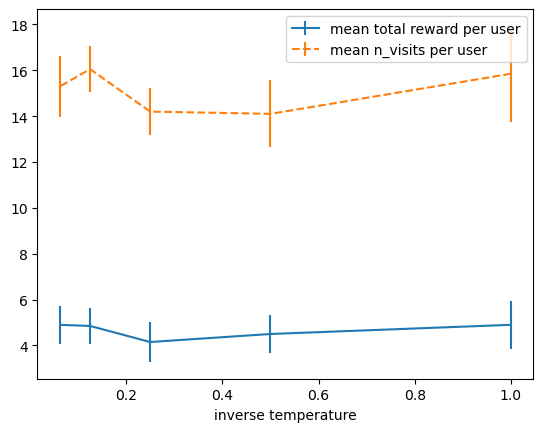

In [10]:
bolt.plot_temp_sweep(s_temp['ipp'], 'inhomogeneous') 

INV TEMP 1
INV TEMP 0.5
INV TEMP 0.25
INV TEMP 0.125
INV TEMP 0.0625


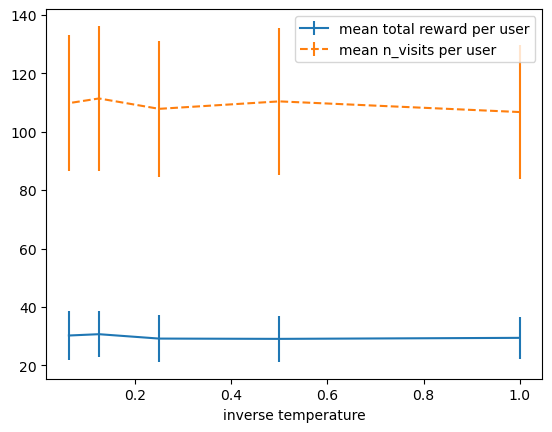

In [11]:
bolt.plot_temp_sweep(s_temp['pp'], 'homogenous')    